# Implementation of DLRM (Full/Regular/APFL) 

## Imports

In [2]:
SYFT_VERSION = ">=0.8.2.b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# %pip install {package_string} -q

import tensorflow as tf
from tensorflow.keras.metrics import AUC
# syft absolute
import syft as sy

sy.requires(SYFT_VERSION)

import pandas as pd
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


✅ The installed version of syft==0.8.4 matches the requirement >=0.8.2b0 and the requirement <0.9


## Load and preprocess the data

In [3]:
# Load the dataset and fill the nan with 0
columns = ['label', *(f'I{i}' for i in range(1, 14)), *(f'C{i}' for i in range(1, 27))]
df = pd.read_csv('/Users/alex/Thesis/New Dataset/train.txt', sep='\t', names=columns).fillna(0)
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,0,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,0,0,e587c466,ad3062eb,3a171ecb,3b183c5c,0,0
3,0,0.0,893,0.0,0.0,4392.0,0.0,0.0,0.0,0.0,...,1e88c74f,74ef3502,0,0,6b3a5ca6,0,3a171ecb,9117a34a,0,0
4,0,3.0,-1,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,0,0,21c9516a,0,32c7478e,b34f3128,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364724,0,0.0,2,0.0,2.0,41171.0,90.0,0.0,2.0,47.0,...,07c540c4,ab194a92,0,0,21c9516a,0,32c7478e,b34f3128,0,0
1364725,0,0.0,3,7.0,10.0,3912.0,400.0,2.0,17.0,104.0,...,e5ba7672,698d1c68,0,0,08119c8b,0,32c7478e,f96a556f,0,0
1364726,0,0.0,1,48.0,0.0,17375.0,0.0,0.0,0.0,0.0,...,e5ba7672,7b06fafe,2f4b9dd2,a458ea53,033d948f,0,32c7478e,226b0ab6,2bf691b1,9aed84e6
1364727,0,0.0,0,49.0,2.0,16610.0,0.0,0.0,6.0,0.0,...,1e88c74f,c21c3e4c,efa3470f,a458ea53,d3563291,0,bcdee96c,f88869fd,9b3e8820,86fe1bbe


In [4]:
# Preprocess Dense Features
dense_cols = [c for c in columns if 'I' in c]
df[dense_cols] = preprocessing.StandardScaler().fit_transform(df[dense_cols])
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.126764,-0.267956,-0.039644,-0.661748,-0.250526,-0.228230,0.020912,-0.391033,0.389777,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,0.018618,-0.270689,0.104480,-0.536490,-0.269520,-0.217521,-0.208636,-0.391033,-0.454746,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,0,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,0.018618,-0.270689,-0.054426,1.091864,-0.259652,-0.000653,-0.173320,-0.391033,0.695141,...,8efede7f,3412118d,0,0,e587c466,ad3062eb,3a171ecb,3b183c5c,0,0
3,0,-0.272146,2.170260,-0.058121,-0.661748,-0.205861,-0.238940,-0.243951,-0.460362,-0.473831,...,1e88c74f,74ef3502,0,0,6b3a5ca6,0,3a171ecb,9117a34a,0,0
4,0,0.164000,-0.273423,-0.058121,-0.661748,-0.271004,-0.238940,-0.190978,-0.460362,-0.473831,...,1e88c74f,26b3c7a7,0,0,21c9516a,0,32c7478e,b34f3128,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364724,0,-0.272146,-0.265222,-0.058121,-0.411232,0.339901,0.002024,-0.243951,-0.391033,-0.249579,...,07c540c4,ab194a92,0,0,21c9516a,0,32c7478e,b34f3128,0,0
1364725,0,-0.272146,-0.262489,-0.032253,0.590832,-0.212983,0.832010,-0.208636,0.128934,0.022386,...,e5ba7672,698d1c68,0,0,08119c8b,0,32c7478e,f96a556f,0,0
1364726,0,-0.272146,-0.267956,0.119262,-0.661748,-0.013207,-0.238940,-0.243951,-0.460362,-0.473831,...,e5ba7672,7b06fafe,2f4b9dd2,a458ea53,033d948f,0,32c7478e,226b0ab6,2bf691b1,9aed84e6
1364727,0,-0.272146,-0.270689,0.122957,-0.411232,-0.024558,-0.238940,-0.243951,-0.252375,-0.473831,...,1e88c74f,c21c3e4c,efa3470f,a458ea53,d3563291,0,bcdee96c,f88869fd,9b3e8820,86fe1bbe


In [5]:
# Preprocess Categorical Features
cat_cols = [c for c in columns if 'C' in c]
mappings = {
    col: dict(zip(values, range(len(values))))
    for col, values in map(lambda col: (col, df[col].unique()), cat_cols)
}
for col, mapping in mappings.items():
    df[col] = df[col].map(mapping.get)
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.126764,-0.267956,-0.039644,-0.661748,-0.250526,-0.228230,0.020912,-0.391033,0.389777,...,0,0,0,0,0,0,0,0,0,0
1,0,0.018618,-0.270689,0.104480,-0.536490,-0.269520,-0.217521,-0.208636,-0.391033,-0.454746,...,1,1,0,1,1,0,0,1,0,1
2,0,0.018618,-0.270689,-0.054426,1.091864,-0.259652,-0.000653,-0.173320,-0.391033,0.695141,...,2,2,1,2,2,1,0,2,1,2
3,0,-0.272146,2.170260,-0.058121,-0.661748,-0.205861,-0.238940,-0.243951,-0.460362,-0.473831,...,3,3,1,2,3,0,0,3,1,2
4,0,0.164000,-0.273423,-0.058121,-0.661748,-0.271004,-0.238940,-0.190978,-0.460362,-0.473831,...,3,4,1,2,4,0,1,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364724,0,-0.272146,-0.265222,-0.058121,-0.411232,0.339901,0.002024,-0.243951,-0.391033,-0.249579,...,1,246,1,2,4,0,1,4,1,2
1364725,0,-0.272146,-0.262489,-0.032253,0.590832,-0.212983,0.832010,-0.208636,0.128934,0.022386,...,0,21,1,2,144,0,1,20,1,2
1364726,0,-0.272146,-0.267956,0.119262,-0.661748,-0.013207,-0.238940,-0.243951,-0.460362,-0.473831,...,0,88,96,3,315255,0,1,2096,11,5419
1364727,0,-0.272146,-0.270689,0.122957,-0.411232,-0.024558,-0.238940,-0.243951,-0.252375,-0.473831,...,3,49,73,3,315256,0,8,29121,3,22213


In [6]:
label_counts = df.groupby('label')['I1'].count()
print(f'Baseline: {max(label_counts.values) / sum(label_counts.values) * 100}%')

Baseline: 74.63203317288634%


In [7]:
# Shuffle the DataFrame rows
df_shuffled = df.sample(frac=1).reset_index(drop=True)

# Calculate the index for splitting
first_split = int(len(df_shuffled) * 1/2)
second_split = first_split + int(len(df_shuffled) * 1/2)

# Split the DataFrame into three parts
df1 = df_shuffled.iloc[:first_split]
df2 = df_shuffled.iloc[first_split:second_split]

df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)

# Verifying the splits
print(f"Total records: {len(df)}")
print(f"df1 records: {len(df1)}")
print(f"df2 records: {len(df2)}")

Total records: 1364729
df1 records: 682364
df2 records: 682364


In [8]:
dense_cols = [c for c in df.columns if 'I' in c]
cat_cols = [c for c in df.columns if 'C' in c]
fixed_embedding_size = 455000
emb_counts = [len(df[c].unique()) for c in cat_cols]

## Data Owner 1

In [9]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df1)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df1[dense_cols].values, tf.float32),
        tf.cast(df1[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df1['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [10]:
def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()

    for units in arch[:-1]:
        mlp.add(tf.keras.layers.Dense(units, activation=activation))

    mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))

    return mlp


class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interaction=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)

        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)

        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2)

        if not self.self_interaction:
            mask = mask - tf.linalg.band_part(ones, 0, 0)
            out_dim = int(len(inputs) * (len(inputs) - 1) / 2)

        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions


class DLRM(tf.keras.Model):
    def __init__(
            self,
            embedding_sizes,
            embedding_dim,
            arch_bot,
            arch_top,
            self_interaction,
    ):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, input):
        input_dense, input_cat = input
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

In [11]:
model = DLRM(
    embedding_sizes=emb_counts,
    embedding_dim=2,
    arch_bot=[8, 2],
    arch_top=[128, 64, 2],
    self_interaction=False
)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]  
)

In [12]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
4265/4265 [==============================] - 141s 33ms/step - loss: 0.5178 - accuracy: 0.7586 - auc: 0.8222 - val_loss: 0.4896 - val_accuracy: 0.7704 - val_auc: 0.8445
Epoch 2/5
4265/4265 [==============================] - 221s 52ms/step - loss: 0.4688 - accuracy: 0.7795 - auc: 0.8586 - val_loss: 0.4835 - val_accuracy: 0.7715 - val_auc: 0.8490
Epoch 3/5
4265/4265 [==============================] - 209s 49ms/step - loss: 0.4391 - accuracy: 0.7971 - auc: 0.8776 - val_loss: 0.4920 - val_accuracy: 0.7671 - val_auc: 0.8450
Epoch 4/5
4265/4265 [==============================] - 187s 44ms/step - loss: 0.4080 - accuracy: 0.8152 - auc: 0.8956 - val_loss: 0.5161 - val_accuracy: 0.7617 - val_auc: 0.8353
Epoch 5/5
4265/4265 [==============================] - 202s 47ms/step - loss: 0.3782 - accuracy: 0.8312 - auc: 0.9110 - val_loss: 0.5360 - val_accuracy: 0.7598 - val_auc: 0.8301


In [13]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2632      
                                                                 
 embedding_1 (Embedding)     multiple                  1066      
                                                                 
 embedding_2 (Embedding)     multiple                  849010    
                                                                 
 embedding_3 (Embedding)     multiple                  303040    
                                                                 
 embedding_4 (Embedding)     multiple                  558       
                                                                 
 embedding_5 (Embedding)     multiple                  32        
                                                                 
 embedding_6 (Embedding)     multiple                  22222  

In [14]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

853/853 [==============================] - 18s 13ms/step - loss: 0.5416 - accuracy: 0.7530 - auc: 0.8258
Loss: 0.5415992736816406, Accuracy: 0.7529561519622803, AUC: 0.8258227705955505


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.517849,0.758646,0.822196,0.489572,0.770389,0.844450
1,0.468824,0.779511,0.858590,0.483483,0.771525,0.849001
2,0.439088,0.797079,0.877613,0.491967,0.767055,0.844971
3,0.407954,0.815223,0.895594,0.516147,0.761669,0.835342
4,0.378249,0.831151,0.910979,0.536010,0.759801,0.830051


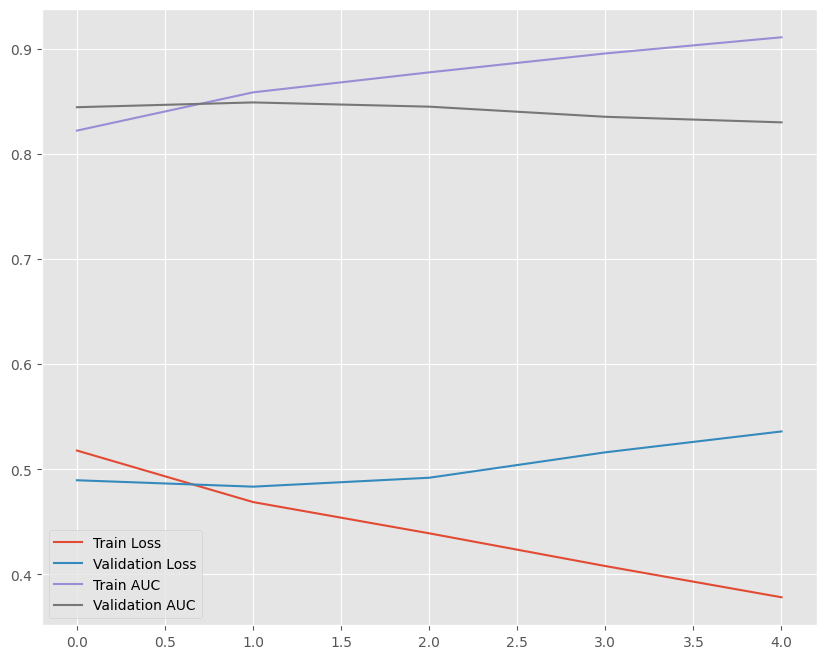

Validation AUC: 0.8297


In [15]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = model.metrics_names.index('auc')
auc_score_baseline1 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline1:.4f}")

In [16]:
import numpy as np

def add_noise_to_weights(weights, noise_std=0.01):
    """Adds Gaussian noise to a dictionary of weights."""
    noisy_weights = {}
    for key, weight in weights.items():
        # Generating Gaussian noise with the same shape as the weight
        noise = np.random.normal(loc=0.0, scale=noise_std, size=weight.shape)
        # Adding the noise to the weight
        noisy_weight = weight + noise
        noisy_weights[key] = noisy_weight
    return noisy_weights

# Extract the model's weights into a dictionary
model_weights_dict_1 = {v.name: v.numpy() for v in model.trainable_variables}

# Add noise to the model's weights
noisy_model_weights_dict_1 = add_noise_to_weights(model_weights_dict_1, noise_std=0.01)

# Now, noisy_model_weights_dict contains the weights with added Gaussian noise

In [31]:
node = sy.orchestra.launch(name="test-domain-1", port="auto", dev_mode=True, reset=True)

Staging Protocol Changes...
Starting test-domain-1 server on 0.0.0.0:58015
Waiting for server to start....

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


.

INFO:     Started server process [44348]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:57342 (Press CTRL+C to quit)


..............

Login to the Domain

In [32]:
domain_client = node.login(email="info@openmined.org", password="changethis")

INFO:     Started server process [44358]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:58015 (Press CTRL+C to quit)



SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/7bca415d13ed4ec881f0d0aede098dbb.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=25c7420dac044eb2879a426be9666d80 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
INFO:     127.0.0.1:53238 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:53238 - "GET /api/v2/metadata HTTP/1.1" 200 OK
Logged into <test-domain-1: High-side Domain> as GUEST
INFO:     127.0.0.1:53238 - "POST /api/v2/login HTTP/1.1" 200 OK
INFO:     127.0.0.1:53238 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:53252 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Logged into <test-domain-1: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Initialize Model Weights

In [33]:
# Convert the trained model parameters to a Syft ActionObject
model_weights_obj = sy.ActionObject.from_obj(noisy_model_weights_dict_1)

# Check the object type and attributes
print(type(model_weights_obj.syft_action_data), model_weights_obj.id)


<class 'dict'> 4f0a13e806154e3f8893652f0eb8f202


In [34]:
# Set the model weights ActionObject in the domain
weight_domain_obj = domain_client.api.services.action.set(model_weights_obj)

# Check the domain object attributes
print(weight_domain_obj.id)


INFO:     127.0.0.1:53264 - "POST /api/v2/api_call HTTP/1.1" 200 OK
4f0a13e806154e3f8893652f0eb8f202


Convert Model Weights to Syft ActionObject:

Define a Weights Access function

In [35]:
@sy.syft_function(
    input_policy=sy.ExactMatch(weights=weight_domain_obj.id),
    output_policy=sy.SingleExecutionExactOutput(),
)
def fetch_weights(weights):
    # Simply return the weights; no computation needed
    return weights


INFO:     127.0.0.1:53275 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53277 - "GET /api/v2/metadata HTTP/1.1" 200 OK


SyftSuccess: Syft function 'fetch_weights' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Access Weights

In [36]:
weights_pointer = fetch_weights(weights=weight_domain_obj)
weights_local = weights_pointer.get()

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/8d652819cdbd4613b96490753867a61c.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=c6b420af00df4c25a5a0690195275ba5 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_4438: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:53288 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53294 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_4438
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieve and Verify the Output

Request and Approve Code Execution

In [37]:
request = domain_client.code.request_code_execution(fetch_weights)
request

INFO:     127.0.0.1:53362 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53365 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:53388 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53390 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53392 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53394 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53396 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53398 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53400 - "POST /api/v2/api_call HTTP/1.1" 200 OK


syft.service.request.request.Request

In [38]:
request.approve()

INFO:     127.0.0.1:53403 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:53405 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53407 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53409 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53411 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53413 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53415 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53418 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain test-domain-1
INFO:     127.0.0.1:53420 - "POST /api/v2/api_call HTTP/1.1" 200 OK


SyftSuccess: Request 1880f8d3c1594fdfa999b88a68c0f65f changes applied

In [39]:
domain_client._api = None
_ = domain_client.api

INFO:     127.0.0.1:53403 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK


Fetching the pointer and the actual weights

In [40]:
# Fetch the weights pointer from the domain
weights_ptr = fetch_weights(weights=weight_domain_obj)

# Retrieve the actual weights from the pointer
weights_local = weights_ptr.get()


SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/e057465cfea44b5f921e11825e3039b6.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=8449c163a09f429c948682c64de6894a in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_1217: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:53428 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53430 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_1217
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieving the Computation Result

Cleanup and Land the Node

In [41]:
if node.node_type.value == "python":
    node.land()

## Data Owner 2

In [42]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df2)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df2[dense_cols].values, tf.float32),
        tf.cast(df2[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df2['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [43]:
def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()

    for units in arch[:-1]:
        mlp.add(tf.keras.layers.Dense(units, activation=activation))

    mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))

    return mlp


class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interaction=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)

        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)

        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2)

        if not self.self_interaction:
            mask = mask - tf.linalg.band_part(ones, 0, 0)
            out_dim = int(len(inputs) * (len(inputs) - 1) / 2)

        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions


class DLRM(tf.keras.Model):
    def __init__(
            self,
            embedding_sizes,
            embedding_dim,
            arch_bot,
            arch_top,
            self_interaction,
    ):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, input):
        input_dense, input_cat = input
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

In [44]:
model = DLRM(
    embedding_sizes=emb_counts,
    embedding_dim=2,
    arch_bot=[8, 2],
    arch_top=[128, 64, 2],
    self_interaction=False
)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]  
)

In [45]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
4265/4265 [==============================] - 392s 86ms/step - loss: 0.5095 - accuracy: 0.7628 - auc: 0.8295 - val_loss: 0.4826 - val_accuracy: 0.7745 - val_auc: 0.8494
Epoch 2/5
4265/4265 [==============================] - 310s 73ms/step - loss: 0.4637 - accuracy: 0.7830 - auc: 0.8621 - val_loss: 0.4758 - val_accuracy: 0.7765 - val_auc: 0.8544
Epoch 3/5
4265/4265 [==============================] - 177s 41ms/step - loss: 0.4355 - accuracy: 0.7995 - auc: 0.8798 - val_loss: 0.4867 - val_accuracy: 0.7734 - val_auc: 0.8502
Epoch 4/5
4265/4265 [==============================] - 158s 37ms/step - loss: 0.4056 - accuracy: 0.8165 - auc: 0.8969 - val_loss: 0.5094 - val_accuracy: 0.7661 - val_auc: 0.8406
Epoch 5/5
4265/4265 [==============================] - 166s 39ms/step - loss: 0.3773 - accuracy: 0.8315 - auc: 0.9115 - val_loss: 0.5342 - val_accuracy: 0.7571 - val_auc: 0.8303


In [46]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2632      
                                                                 
 embedding_1 (Embedding)     multiple                  1066      
                                                                 
 embedding_2 (Embedding)     multiple                  849010    
                                                                 
 embedding_3 (Embedding)     multiple                  303040    
                                                                 
 embedding_4 (Embedding)     multiple                  558       
                                                                 
 embedding_5 (Embedding)     multiple                  32        
                                                                 
 embedding_6 (Embedding)     multiple                  22222  

In [47]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

853/853 [==============================] - 37s 21ms/step - loss: 0.5385 - accuracy: 0.7539 - auc: 0.8263
Loss: 0.5384869575500488, Accuracy: 0.7538903951644897, AUC: 0.8262622356414795


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.509519,0.762758,0.829494,0.482609,0.774456,0.849443
1,0.463692,0.782982,0.862064,0.475832,0.776544,0.854352
2,0.435548,0.799530,0.879804,0.486702,0.773357,0.850184
3,0.405648,0.816469,0.896900,0.509373,0.766102,0.840593
4,0.377293,0.831541,0.911502,0.534163,0.757089,0.830252


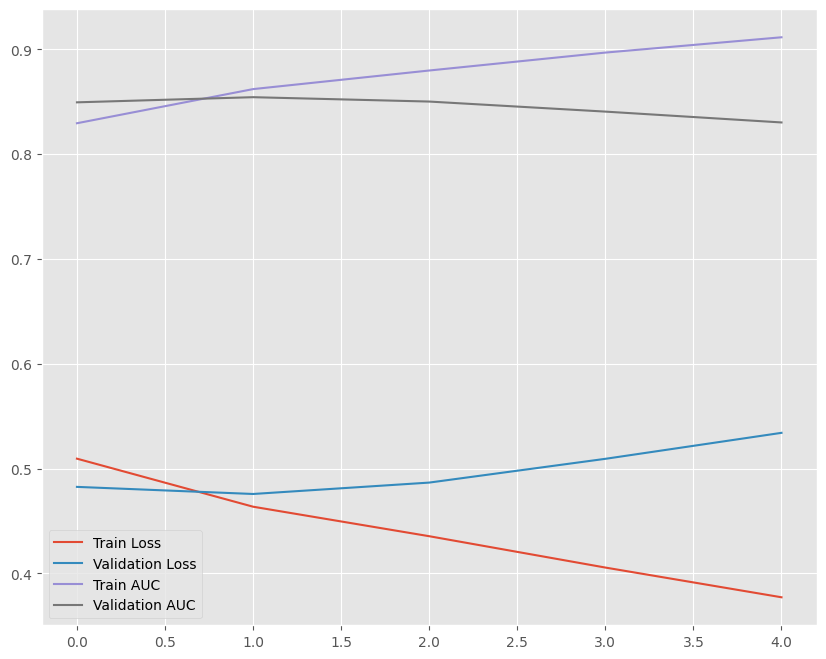

Validation AUC: 0.8302


In [48]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = model.metrics_names.index('auc')
auc_score_baseline2 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline2:.4f}")

In [49]:
import numpy as np

def add_noise_to_weights(weights, noise_std=0.01):
    """Adds Gaussian noise to a dictionary of weights."""
    noisy_weights = {}
    for key, weight in weights.items():
        # Generating Gaussian noise with the same shape as the weight
        noise = np.random.normal(loc=0.0, scale=noise_std, size=weight.shape)
        # Adding the noise to the weight
        noisy_weight = weight + noise
        noisy_weights[key] = noisy_weight
    return noisy_weights

# Extract the model's weights into a dictionary
model_weights_dict_2 = {v.name: v.numpy() for v in model.trainable_variables}

# Add noise to the model's weights
noisy_model_weights_dict_2 = add_noise_to_weights(model_weights_dict_2, noise_std=0.01)

# Now, noisy_model_weights_dict contains the weights with added Gaussian noise

In [52]:
node_2 = sy.orchestra.launch(name="test-domain-2", port="auto", dev_mode=True, reset=True)

Staging Protocol Changes...
Starting test-domain-2 server on 0.0.0.0:30922
Waiting for server to start.

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


.............

INFO:     Started server process [44718]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:30922 (Press CTRL+C to quit)


.
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/b626124c319343c882a448dac2d6953d.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=317eeb140a424f4989ef5954a2f4c788 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
INFO:     127.0.0.1:54369 - "GET /api/v2/metadata HTTP/1.1" 200 OK
 Done.


Login to the Domain

In [53]:
domain_client_2 = node_2.login(email="info@openmined.org", password="changethis")

INFO:     127.0.0.1:54371 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:54371 - "GET /api/v2/metadata HTTP/1.1" 200 OK
Logged into <test-domain-2: High-side Domain> as GUEST
INFO:     127.0.0.1:54371 - "POST /api/v2/login HTTP/1.1" 200 OK
INFO:     127.0.0.1:54371 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:54374 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Logged into <test-domain-2: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Initialize Model Weights

In [54]:
# Convert the trained model parameters to a Syft ActionObject
model_weights_obj = sy.ActionObject.from_obj(noisy_model_weights_dict_2)

# Check the object type and attributes
print(type(model_weights_obj.syft_action_data), model_weights_obj.id)


<class 'dict'> 43f3457283c34440b71667214d538c8f


In [55]:
# Set the model weights ActionObject in the domain
weight_domain_obj = domain_client_2.api.services.action.set(model_weights_obj)

# Check the domain object attributes
print(weight_domain_obj.id)


INFO:     127.0.0.1:54378 - "POST /api/v2/api_call HTTP/1.1" 200 OK
43f3457283c34440b71667214d538c8f


Convert Model Weights to Syft ActionObject:

Define a Weights Access function

In [56]:
@sy.syft_function(
    input_policy=sy.ExactMatch(weights=weight_domain_obj.id),
    output_policy=sy.SingleExecutionExactOutput(),
)
def fetch_weights(weights):
    # Simply return the weights; no computation needed
    return weights


INFO:     127.0.0.1:54403 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54413 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54417 - "GET /api/v2/metadata HTTP/1.1" 200 OK


SyftSuccess: Syft function 'fetch_weights' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Access Weights

In [57]:
weights_pointer = fetch_weights(weights=weight_domain_obj)
weights_local_2 = weights_pointer.get()

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/94e51811ef7840e1b663689cb514fe4e.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=22961cf9baae454bac32cd8a4aaf94b4 in_memory=True
Timeout elapsed after 30 seconds while trying to acquiring lock.
FAILED TO LOCK
Timeout elapsed after 30 seconds while trying to acquiring lock.
FAILED TO LOCK
Failed to create container: Worker: syft.service.worker.worker_pool.SyftWorker,Error: Failed to acquire lock for the operation
Timeout elapsed after 30 seconds while trying to acquiring lock.
FAILED TO LOCK
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_6856: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:54463 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54465 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_6856
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieve and Verify the Output

Request and Approve Code Execution

In [58]:
request = domain_client_2.code.request_code_execution(fetch_weights)
request

INFO:     127.0.0.1:54482 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54484 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:54486 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54488 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54490 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54492 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54494 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54496 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54498 - "POST /api/v2/api_call HTTP/1.1" 200 OK


syft.service.request.request.Request

In [59]:
request.approve()

INFO:     127.0.0.1:54484 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:54500 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54502 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54504 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54506 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54508 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54510 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54512 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain test-domain-2
INFO:     127.0.0.1:54514 - "POST /api/v2/api_call HTTP/1.1" 200 OK


SyftSuccess: Request 8a9f6e07cf1347619e1c7a8bcfcb3429 changes applied

In [60]:
domain_client_2._api = None
_ = domain_client_2.api

INFO:     127.0.0.1:54484 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK


Fetching the pointer and the actual weights

In [61]:
# Fetch the weights pointer from the domain
weights_ptr = fetch_weights(weights=weight_domain_obj)

# Retrieve the actual weights from the pointer
weights_local_2 = weights_ptr.get()


SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/e9cad00d9f244391bf8ffa50df447c86.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=671f2b1a42864fc4af68bd07b48c2417 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_6615: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:54522 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54524 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_6615
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieving the Computation Result

Cleanup and Land the Node

In [62]:
if node_2.node_type.value == "python":
    node_2.land()

## Data Scientist

In [63]:
weights1 = weights_local
weights2 = weights_local_2

In [64]:
import jax.numpy as jnp

def combine_weights(weights1, weights2):
    """Combines two sets of weights by averaging."""
    global_weights = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights1.keys()) == set(weights2.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights1:
        layer_weights1 = weights1[key]
        layer_weights2 = weights2[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights1.shape == layer_weights2.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights[key] = (layer_weights1 + layer_weights2) / 2
    
    return global_weights


In [65]:
global_weights = combine_weights(weights1, weights_local_2)

# Data Owner 1 with Personalized Model Weights 

In [66]:
import jax.numpy as jnp

def combine_weights(weights1, global_weights, alpha=0.5): #alpha to determine the mix between global and local weights
    """Combines two sets of weights by averaging."""
    global_weights_mix_1 = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights1.keys()) == set(global_weights.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights1:
        layer_weights1 = weights1[key]
        layer_global_weights = global_weights[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights1.shape == layer_global_weights.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights_mix_1[key] = (alpha * layer_weights1 + (1- alpha) * layer_global_weights)
    
    return global_weights_mix_1


In [67]:
global_weights_mix_1 = combine_weights(weights_local, global_weights)

In [68]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df1)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df1[dense_cols].values, tf.float32),
        tf.cast(df1[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df1['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [69]:
embedding_sizes = [emb_count for emb_count in emb_counts]

# Model architecture parameters
embedding_dim = 2
arch_bot = [8, 2]  # Architecture for the bottom MLP (processing dense features)
arch_top = [128, 64, 2]  # Architecture for the top MLP (combining embeddings and processed dense features)

class DLRM(tf.keras.Model):
    def __init__(self, embedding_sizes, embedding_dim, arch_bot, arch_top, self_interaction):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, inputs):
        input_dense, input_cat = inputs
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

# Initialize the model
model = DLRM(
    embedding_sizes=embedding_sizes,
    embedding_dim=embedding_dim,
    arch_bot=arch_bot,
    arch_top=arch_top,
    self_interaction=False
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]
)

# Generate dummy input to build the model
dummy_input_dense = tf.random.uniform((1, len(dense_cols)), dtype=tf.float32)
dummy_input_cat = tf.random.uniform((1, len(cat_cols)), maxval=2, dtype=tf.int32)
model([dummy_input_dense, dummy_input_cat])  # This builds the model's layers

# Set the pre-trained weights
for layer in model.layers:
    if hasattr(layer, 'layers'):  # For nested layers
        for sub_layer in layer.layers:
            if sub_layer.name in global_weights_mix_1:
                sub_layer.set_weights(global_weights_mix_1[sub_layer.name])
    else:
        if layer.name in global_weights_mix_1:
            layer.set_weights(global_weights_mix_1[layer.name])


In [70]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
4265/4265 [==============================] - 471s 108ms/step - loss: 0.5063 - accuracy: 0.7636 - auc: 0.8320 - val_loss: 0.4794 - val_accuracy: 0.7774 - val_auc: 0.8517
Epoch 2/5
4265/4265 [==============================] - 113s 26ms/step - loss: 0.4621 - accuracy: 0.7837 - auc: 0.8632 - val_loss: 0.4760 - val_accuracy: 0.7768 - val_auc: 0.8541
Epoch 3/5
4265/4265 [==============================] - 111s 26ms/step - loss: 0.4332 - accuracy: 0.8006 - auc: 0.8812 - val_loss: 0.4879 - val_accuracy: 0.7736 - val_auc: 0.8501
Epoch 4/5
4265/4265 [==============================] - 336s 79ms/step - loss: 0.4035 - accuracy: 0.8179 - auc: 0.8981 - val_loss: 0.5064 - val_accuracy: 0.7667 - val_auc: 0.8413
Epoch 5/5
4265/4265 [==============================] - 499s 117ms/step - loss: 0.3758 - accuracy: 0.8324 - auc: 0.9122 - val_loss: 0.5279 - val_accuracy: 0.7635 - val_auc: 0.8343


In [71]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2632      
                                                                 
 embedding_1 (Embedding)     multiple                  1066      
                                                                 
 embedding_2 (Embedding)     multiple                  849010    
                                                                 
 embedding_3 (Embedding)     multiple                  303040    
                                                                 
 embedding_4 (Embedding)     multiple                  558       
                                                                 
 embedding_5 (Embedding)     multiple                  32        
                                                                 
 embedding_6 (Embedding)     multiple                  22222  

In [72]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

853/853 [==============================] - 6s 4ms/step - loss: 0.5385 - accuracy: 0.7544 - auc: 0.8274
Loss: 0.5385240912437439, Accuracy: 0.7544216513633728, AUC: 0.8274425864219666


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.506327,0.763565,0.831979,0.479426,0.777424,0.851711
1,0.462052,0.783656,0.863177,0.476049,0.776801,0.854100
2,0.433239,0.800627,0.881186,0.487939,0.773577,0.850058
3,0.403497,0.817916,0.898050,0.506393,0.766725,0.841300
4,0.375820,0.832399,0.912205,0.527880,0.763501,0.834317


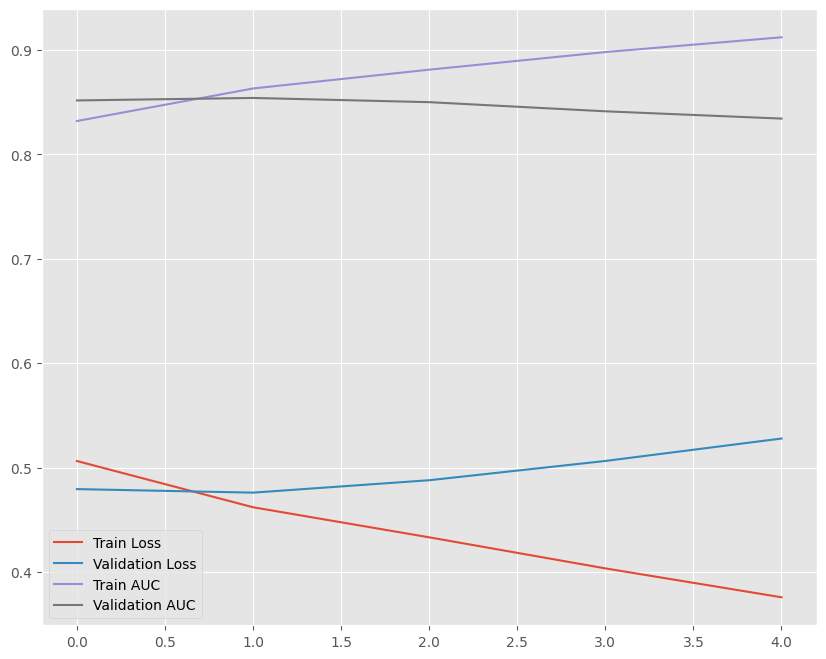

In [73]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()


In [74]:
# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)
val_auc_index = model.metrics_names.index('auc')
val_auc = val_metrics[val_auc_index]

print(f"Validation AUC: {val_auc:.4f}")

Validation AUC: 0.8338


In [75]:
rela_impr = ((val_auc - 0.5) / (auc_score_baseline1 - 0.5)) * 100
print(f"Relative Improvement (RelaImpr): {rela_impr:.2f}%")

Relative Improvement (RelaImpr): 101.25%


# Data Owner 2 with Personalized Model Weights 

In [76]:
import jax.numpy as jnp

def combine_weights(weights2, global_weights, alpha=0.5): #alpha to determine the mix between global and local weights
    """Combines two sets of weights by averaging."""
    global_weights_mix_2 = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights2.keys()) == set(global_weights.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights2:
        layer_weights2 = weights2[key]
        layer_global_weights = global_weights[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights2.shape == layer_global_weights.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights_mix_2[key] = (alpha * layer_weights2 + (1- alpha) * layer_global_weights)
    
    return global_weights_mix_2


In [77]:
global_weights_mix_2 = combine_weights(weights2, global_weights)

In [78]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df2)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df2[dense_cols].values, tf.float32),
        tf.cast(df2[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df2['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [79]:
embedding_sizes = [emb_count for emb_count in emb_counts]

# Model architecture parameters
embedding_dim = 2
arch_bot = [8, 2]  # Architecture for the bottom MLP (processing dense features)
arch_top = [128, 64, 2]  # Architecture for the top MLP (combining embeddings and processed dense features)

class DLRM(tf.keras.Model):
    def __init__(self, embedding_sizes, embedding_dim, arch_bot, arch_top, self_interaction):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, inputs):
        input_dense, input_cat = inputs
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

# Initialize the model
model = DLRM(
    embedding_sizes=embedding_sizes,
    embedding_dim=embedding_dim,
    arch_bot=arch_bot,
    arch_top=arch_top,
    self_interaction=False
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]
)

# Generate dummy input to build the model
dummy_input_dense = tf.random.uniform((1, len(dense_cols)), dtype=tf.float32)
dummy_input_cat = tf.random.uniform((1, len(cat_cols)), maxval=2, dtype=tf.int32)
model([dummy_input_dense, dummy_input_cat])  # This builds the model's layers

# Set the pre-trained weights
for layer in model.layers:
    if hasattr(layer, 'layers'):  # For nested layers
        for sub_layer in layer.layers:
            if sub_layer.name in global_weights_mix_2:
                sub_layer.set_weights(global_weights_mix_2[sub_layer.name])
    else:
        if layer.name in global_weights_mix_2:
            layer.set_weights(global_weights_mix_2[layer.name])


In [80]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
4265/4265 [==============================] - 107s 25ms/step - loss: 0.5115 - accuracy: 0.7603 - auc: 0.8278 - val_loss: 0.4834 - val_accuracy: 0.7724 - val_auc: 0.8489
Epoch 2/5
4265/4265 [==============================] - 147s 34ms/step - loss: 0.4631 - accuracy: 0.7824 - auc: 0.8624 - val_loss: 0.4754 - val_accuracy: 0.7772 - val_auc: 0.8550
Epoch 3/5
4265/4265 [==============================] - 308s 72ms/step - loss: 0.4341 - accuracy: 0.7999 - auc: 0.8806 - val_loss: 0.4883 - val_accuracy: 0.7730 - val_auc: 0.8492
Epoch 4/5
4265/4265 [==============================] - 112s 26ms/step - loss: 0.4042 - accuracy: 0.8175 - auc: 0.8977 - val_loss: 0.5122 - val_accuracy: 0.7660 - val_auc: 0.8409
Epoch 5/5
4265/4265 [==============================] - 82s 19ms/step - loss: 0.3764 - accuracy: 0.8321 - auc: 0.9119 - val_loss: 0.5337 - val_accuracy: 0.7533 - val_auc: 0.8296


In [81]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2632      
                                                                 
 embedding_1 (Embedding)     multiple                  1066      
                                                                 
 embedding_2 (Embedding)     multiple                  849010    
                                                                 
 embedding_3 (Embedding)     multiple                  303040    
                                                                 
 embedding_4 (Embedding)     multiple                  558       
                                                                 
 embedding_5 (Embedding)     multiple                  32        
                                                                 
 embedding_6 (Embedding)     multiple                  22222  

In [82]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

853/853 [==============================] - 8s 5ms/step - loss: 0.5422 - accuracy: 0.7511 - auc: 0.8241
Loss: 0.5422368049621582, Accuracy: 0.7511426210403442, AUC: 0.8240721225738525


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.511472,0.760311,0.827759,0.483375,0.772404,0.848873
1,0.463098,0.782413,0.862376,0.475374,0.777240,0.855034
2,0.434144,0.799911,0.880615,0.488263,0.772954,0.849243
3,0.404174,0.817508,0.897692,0.512219,0.765956,0.840943
4,0.376422,0.832128,0.911914,0.533655,0.753316,0.829579


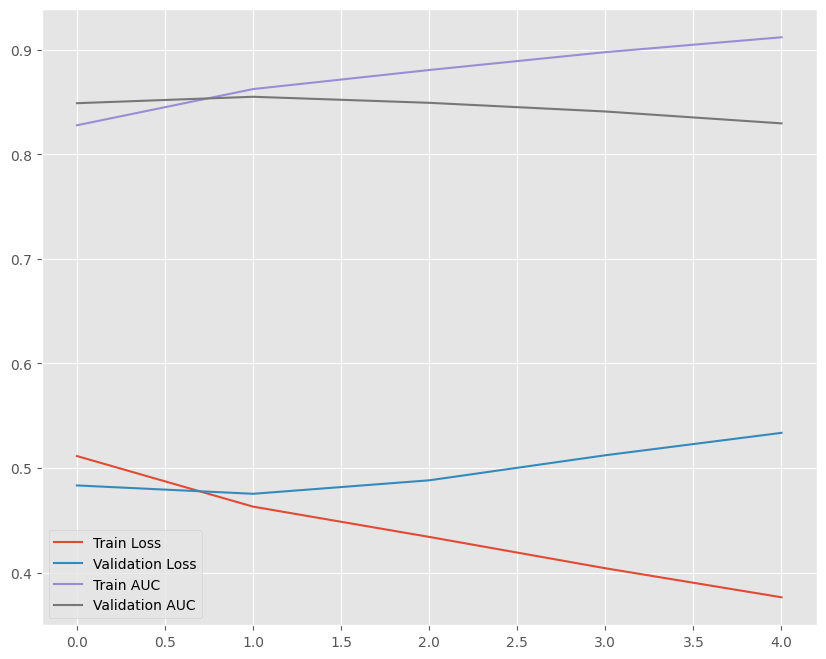

In [83]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()


In [84]:
# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)
val_auc_index = model.metrics_names.index('auc')
val_auc = val_metrics[val_auc_index]

print(f"Validation AUC: {val_auc:.4f}")


Validation AUC: 0.8289


In [85]:
rela_impr = ((val_auc - 0.5) / (auc_score_baseline2 - 0.5)) * 100
print(f"Relative Improvement (RelaImpr): {rela_impr:.2f}%")

Relative Improvement (RelaImpr): 99.63%
